# Fitting PKS 2155-304


In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, RegionGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets, SpectrumDataset
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator
from gammapy.data import DataStore
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Load the data

Here, we use some blazar (PKS 2155-304) runs from the HESS Data release.

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
target_position = SkyCoord(
    329.71693826 * u.deg, -30.2255890 * u.deg, frame="icrs"
)
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


To see what you loaded, you can simply

In [4]:
print(observations)

Observations
Number of observations: 21
Observation

	obs id            : 33787 
 	tstart            : 53945.85
	tstop             : 53945.87
	duration          : 1689.00 s
	pointing (icrs)   : 329.7 deg, -29.7 deg

	deadtime fraction : 2.5%
Observation

	obs id            : 33788 
 	tstart            : 53945.87
	tstop             : 53945.89
	duration          : 1689.00 s
	pointing (icrs)   : 329.1 deg, -30.2 deg

	deadtime fraction : 5.5%
Observation

	obs id            : 33789 
 	tstart            : 53945.89
	tstop             : 53945.91
	duration          : 1688.00 s
	pointing (icrs)   : 330.3 deg, -30.2 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 33790 
 	tstart            : 53945.91
	tstop             : 53945.93
	duration          : 1690.00 s
	pointing (icrs)   : 329.7 deg, -30.7 deg

	deadtime fraction : 7.6%
Observation

	obs id            : 33791 
 	tstart            : 53945.94
	tstop             : 53945.95
	duration          : 1689.00 s
	pointing (icrs)   

## Perform the data reduction

- Define the ON region
- Create an exclusion mask for known Gamma-ray emitting regions
- Define off regions to be extracted
- Run the data reduction chain

### Define the ON region

In [5]:
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Create exclusion mask

Here, we choose a mask of 0.5 deg to the North of the blazar for illustration.
Ideally, this should come from prior knowledge - where you expect gamma ray emission from.

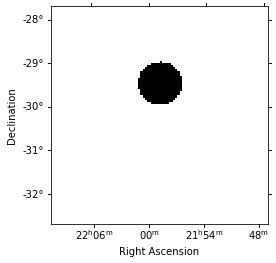

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(329.71, -29.5, unit="deg", frame="icrs"),
    radius=0.5 * u.deg,
)

skydir = target_position.icrs
geom = WcsGeom.create(width=5*u.deg, binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

### Choose off regions

You can choose the 
- `ReflectedRegionsFinder` :  A set of OFF counts is found in the observation, by rotating the ON region selected around the pointing position (https://docs.gammapy.org/0.20/tutorials/analysis/1D/spectral_analysis.html). 
- `WobbleRegionsFinder` : Customise the selection of your off regions. This can be useful if you have energy dependent rad-max cuts (https://docs.gammapy.org/0.20/tutorials/analysis/1D/spectral_analysis_rad_max.html) or, you want to have more control on your region selection

Here, we show an example with (2)

In [7]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

In [8]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 3 off
region_finder = WobbleRegionsFinder(n_off_regions=2)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

In [9]:
datasets = Datasets()

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=observation.obs_id), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

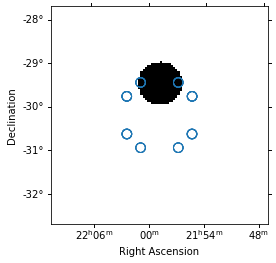

In [10]:
# create a counts map for visualisation later...
ax = exclusion_mask.plot()
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)



In [11]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,92,82.5,10.767284240561896,9.5,37.0,37.0,nan,2947134.75,938974976.0,1645.943673139438,1689.0,0.05589498687067532,0.005771764948602343,0.050123221922072976,27,16,wstat,124.76800428147962,19,16.0,32.0,0.5
stacked,509,492.5,29.94129658755475,16.5,180.66666666666669,180.66666666666669,nan,3549790.25,1579164160.0,3242.045464714989,3378.0,0.15699964899929206,0.005089379584456422,0.15191026941483565,27,18,wstat,918.911068742291,33,18.0,36.0,0.5
stacked,1321,1297.0,50.25435679615148,24.0,456.33333333333326,456.33333333333326,nan,38543.67578125,2112657792.0,4825.489054074511,5066.0,0.2737546360994403,0.004973589149422079,0.2687810469500182,27,19,wstat,2562.036379919156,48,19.0,38.0,0.5
stacked,2206,2174.0,65.6963552880217,32.0,756.6666666666665,756.6666666666665,nan,163008.84375,2542220032.0,6386.866192122921,6756.0,0.3453963076165137,0.0050102818874562275,0.34038602572905746,27,20,wstat,4361.224431259612,64,20.0,40.0,0.5
stacked,3158,3115.5,78.87293197387494,42.5,1081.0,1081.0,nan,511079.96875,2910420224.0,7954.743777347729,8445.0,0.3969958163822771,0.005342723938013545,0.39165309244426355,27,21,wstat,6276.397263825995,85,21.0,42.0,0.5
stacked,3932,3881.0,88.15091984637475,51.0,1344.6666666666667,1344.6666666666667,nan,3783955.5,3232583424.0,9517.102900041267,10133.0,0.4131509390302957,0.005358773624248495,0.4077921654060472,27,21,wstat,7836.385501603602,102,21.0,42.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,7759,7623.5,122.05956372095592,135.5,2676.6666666666665,2676.6666666666665,nan,45967708.0,7560449024.0,25258.837867734954,27021.0,0.30717961137519967,0.005364458994888459,0.3018151523803112,27,22,wstat,15042.248207141676,271,22.0,44.0,0.5


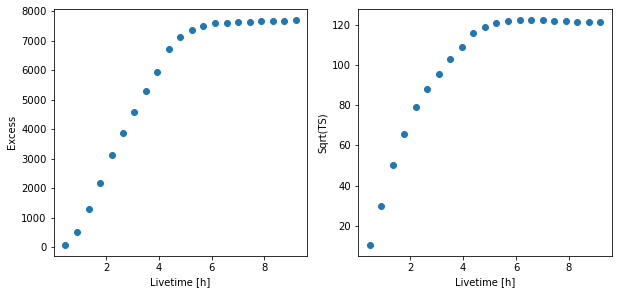

In [12]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax1.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
ax1.set_xlabel("Livetime [h]")
ax1.set_ylabel("Excess");


ax2 = plt.subplot(222)
ax2.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
ax2.set_xlabel("Livetime [h]")
ax2.set_ylabel("Sqrt(TS)");


### Save the DL3 files

In [13]:
datasets.write("DL3-1D.fitz.gz", overwrite=True)

In [14]:
#create stacked
stacked = datasets.stack_reduce()

In [15]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : xI4drIqv 

  Total counts                    : 7878 
  Total background counts         : 176.00
  Total excess counts             : 7702.00

  Predicted counts                : 2743.33
  Predicted background counts     : 2743.33
  Predicted excess counts         : nan

  Exposure min                    : 4.60e+07 m2 s
  Exposure max                    : 9.70e+09 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 22 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14878.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 352 
  Acceptance                      : 27 
  Acceptance off                  : 54 



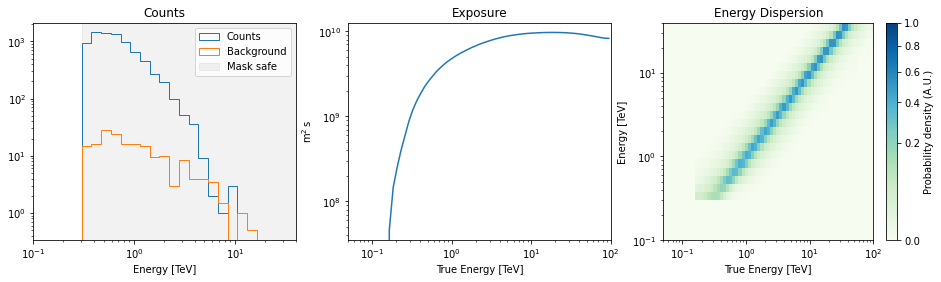

In [16]:
stacked.peek()

## Data Fitting
- What is the significance of the detected source?
- Can we detect a cutoff in the observed spectrum?
- H0: Background only
- H1: Power law model
- H2: Cutoff power law

This logic can be generalised to other questions - is the source extended/variable/etc

In [17]:
#explain global Models object
models = Models()

In [18]:
## Background only - the wstat background 

In [19]:
L0 = stacked.stat_sum()
print(L0)

14878.042748558766


<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

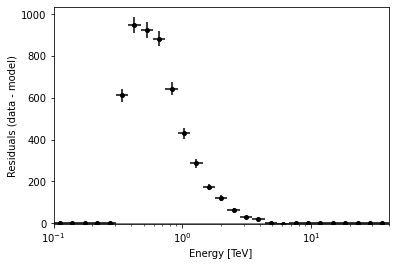

In [20]:
stacked.plot_residuals_spectral()

### Now, add a source model
- Need to consider EBL absorption (see: https://docs.gammapy.org/0.20/modeling/gallery/spectral/plot_absorbed.html?highlight=ebl)

In [21]:
spectral_model = ExpCutoffPowerLawSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
spectral_model1 = spectral_model*ebl
pks_model = SkyModel(spectral_model=spectral_model1,
                    name="pks_model")

In [22]:
pks_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,1.5000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,lambda_,1.0000e-01,TeV-1,0.000e+00,nan,nan,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [23]:
spectral_model.amplitude.value = 1e-12
spectral_model.index.value = 2.0
spectral_model.lambda_.value = 0.0
spectral_model.lambda_.frozen = True # Behaves as a power law, cutoff fixed at infty

In [24]:
models = pks_model

In [25]:
stacked.models = models

In [26]:
stacked.models.names

['pks_model']

In [27]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[stacked])

CPU times: user 662 ms, sys: 3.07 ms, total: 665 ms
Wall time: 664 ms


In [28]:
result2.success

True

In [29]:
models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.8450e+00,,2.314e-02,nan,nan,False,False,
spectral,amplitude,1.9273e-10,cm-2 s-1 TeV-1,3.337e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [30]:
L1 = result2.total_stat
print("del TS of detection: ", (L0-L1), chi2.sf((L0-L1), 4))

del TS of detection:  14725.614606155135 0.0


<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

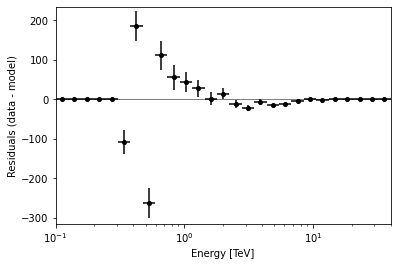

In [31]:
stacked.plot_residuals_spectral()

#### Get flux points

In [32]:
energy_edges = np.logspace(-1, 1.6, 12)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name, selection_optional=["ul"])

In [33]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 2.92 s, sys: 64.2 ms, total: 2.99 s
Wall time: 2.91 s


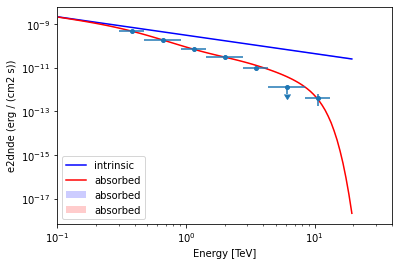

In [34]:
ax = spectral_model.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model1.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", facecolor="blue")
spectral_model1.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend()

### Now, search for cutoff

In [35]:
spectral_model.lambda_.frozen = False

In [36]:
%%time
fit3 = Fit(optimize_opts={"print_level": 1})
result3 = fit3.run(datasets=[stacked])

CPU times: user 466 ms, sys: 5.11 ms, total: 472 ms
Wall time: 473 ms


In [37]:
models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.4676e+00,,7.190e-02,nan,nan,False,False,
spectral,amplitude,3.1709e-10,cm-2 s-1 TeV-1,2.955e-11,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,lambda_,4.2215e-01,TeV-1,8.046e-02,nan,nan,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [38]:
L2 = result3.total_stat
print("del TS of cutoff: ",(L1-L2), "p-value: ", chi2.sf((L1-L2),1))

del TS of cutoff:  37.873645056317415 p-value:  7.54780142191898e-10


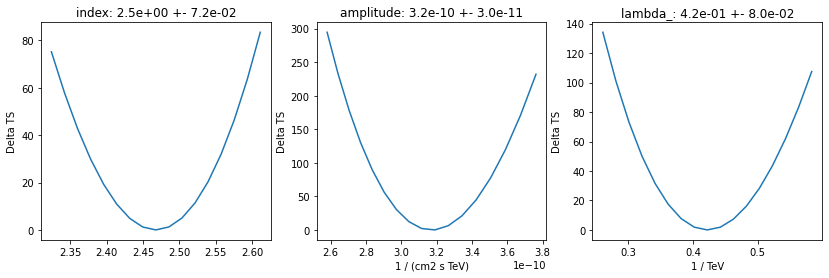

In [39]:
### See a likelihood scan of free parameters
total_stat = result3.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit3.stat_profile(datasets=[stacked], parameter=par)
    ax.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

<AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>

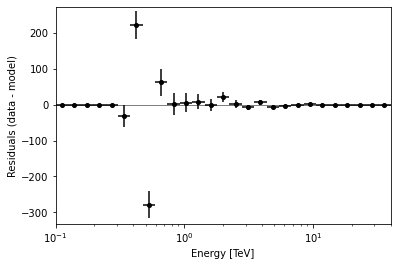

In [40]:
stacked.plot_residuals_spectral()

#### Get flux points

In [41]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 2.75 s, sys: 43.1 ms, total: 2.79 s
Wall time: 2.7 s


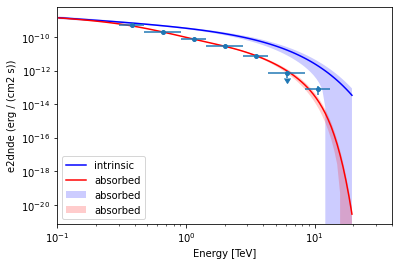

In [42]:
ax = spectral_model.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model1.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", facecolor="blue")
spectral_model1.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend()

In [43]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
0.12484541354466076,0.10000000000000002,0.1558637728313736,4.909442916390356e-08,2.772549984293527e-09,3.3992190978803226e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.21742229366110305,0.1558637728313736,0.3032934011676863,1.0899856768881693e-08,1.660016931932732e-09,3.436746906979284e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.37864790094146483,0.3032934011676863,0.47272453780854895,2.0017356292205224e-09,3.4833365941215153e-10,1.281528020171072e-10,1.0891684327607805,0.022747593109355993,1.135283594354454,4656.738207339109,68.24029753260979,2369.1016668569973,2338.1553,23.459968267872682,False,2369.0,True
0.6594274693415539,0.47272453780854895,0.9198688719186309,2.8548642488661583e-10,1.4133616050144162e-10,8.62676728154788e-11,0.9440546834804646,0.015807309262759632,0.9760115663944957,7102.328178304417,84.27531179594898,3738.2835534230444,3669.431,39.99107980757253,False,3739.0,True
1.1484140972154202,0.9198688719186309,1.4337423288737732,3.5412123425229075e-11,1.9225419261417e-11,2.1285376379514256e-11,1.0135438254276423,0.031545202977236966,1.0780548899091706,2001.399277436154,44.73700121192919,1107.7877099723707,1076.77,0.033817020477727056,False,1108.0,True
2.0,1.4337423288737732,2.789901587924842,4.3818008688824956e-12,6.659900090764804e-12,1.2246233255743486e-11,1.040050154423628,0.0463180059186515,1.135266992453803,946.5792914942522,30.76652875275747,559.5706001232945,536.8678,1.836610650884836,False,560.0,True
3.483064174933826,2.789901587924842,4.34844587322206,4.032932248598544e-13,6.88502921929589e-13,2.2743906954133174e-12,0.9869755731048179,0.12861600617258379,1.2607128989896774,90.76599662863961,9.52711900989169,86.86652226497397,74.30334,2.463957787772017,False,87.0,True
6.065868023353727,4.34844587322206,8.461587415248545,1.6641010297924993e-14,1.0560784904879006e-13,5.46594939135668e-13,0.23392794793565147,0.23389520978893197,0.7555723255378567,1.0704194772666824,1.0346107854003275,12.711231272721545,4.066076,2.351479963691603,True,12.0,True


We have successfully detected a cutoff in the observed spectrum.

## Exercises:


- Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/0.19/modeling/gallery/index.html 

- Simulate synthetic datasets to test the stability of the fit

- Use different off regions and repeat

- Repeat exercise on the Crab runs available in GAMMAPY_DATA. Alternatively, if you have access to CTA DC1 simulated data, repeat on your favourite source 
